In [1]:
import sys
import cv2
import numpy as np
#sys.path.insert(0, '/home/ubuntu/caffe/python')
#sys.path.insert(0, '/home/ubuntu/py-R-FCN/caffe/python')
sys.path.insert(0, '/home/ubuntu/py-faster-rcnn/caffe-fast-rcnn/python')
import matplotlib 
matplotlib.use('Agg')
import caffe
import pprint
#sys.path.insert(0, '/home/ubuntu/py-R-FCN/lib')
sys.path.insert(0, '/home/ubuntu/py-faster-rcnn/lib')
from fast_rcnn.config import cfg, cfg_from_file
from fast_rcnn.test import im_detect
import os
from sklearn.manifold import TSNE
from fast_rcnn.nms_wrapper import nms
import matplotlib.pyplot as plt
from sklearn import decomposition
import heapq
import random

#import bhtsne
%matplotlib inline

/home/ubuntu/py-faster-rcnn/caffe-fast-rcnn/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/home/ubuntu/py-faster-rcnn/caffe-fast-rcnn/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/home/ubuntu/py-faster-rcnn/caffe-fast-rcnn/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


In [2]:
from PIL import Image
from matplotlib import offsetbox
import matplotlib.patches as mpatches
import random
test_name = 'test'
test_files = []
caffe_dir = '/home/ubuntu/py-faster-rcnn/caffe-fast-rcnn'
try1_dir = '/home/ubuntu/try1'
with open(os.path.join(try1_dir, 'data/ImageSets/')+test_name+'.txt') as f:
    num_lines = 0
    for file_ in f.readlines():
        num_lines += 1
        test_files.append(file_.strip())

def plot_2annotations(X, y1, y2, subset=False, images=False):
    ''' 
    Compare annotations y1 and y2
    '''
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    
    count1 = 0
    count2 = 0
    plt.figure(figsize=(20, 20),dpi=160,facecolor='w', edgecolor='k')
    ax = plt.subplot(211)
    patches = []
    for i in range(X.shape[0]):
        if i not in subset:
            continue
        if y1[i] == y2[i] or y1[i] == 7 or y2[i] == 7:
            count1 +=1
            plt.plot(X[i, 0], X[i, 1],marker='o',markersize=6,color=plt.cm.Set1(y[i] / len(CLASSES)),markeredgecolor='none')
        else:
            count2 +=1
            plt.plot(X[i, 0], X[i, 1],marker='o',markersize=6,color=plt.cm.Set1(.999),markeredgecolor='none')

    print count1, count2
    #legend
    for yi in range(len(CLASSES)):
        patches.append(mpatches.Patch(color=plt.cm.Set1(yi*1.0 / len(CLASSES)), label=str(CLASSES[yi])))
    patches.append(mpatches.Patch(color=plt.cm.Set1(.999), label='mismatch'))
    plt.legend(handles=patches)
    plt.xticks([]), plt.yticks([])
    if images is not False:
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 5e-4:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            filename = images[i]
            img = Image.open(os.path.join(caffe_dir, 'examples/try1/test', filename))
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(img.resize((30,30))),X[i], pad=0.2, bboxprops =dict(color=plt.cm.Set1(y[i] / len(CLASSES))))
            ax.add_artist(imagebox) ##
            
# Scale and visualize the embedding vectors
def plot_embedding(X, y, title=None, coordinates=False, images=False):
    ''' 
    coordinates: list of list
    images: if coordinates exist, list of corresponding filename indices for full images (to be cropped using coordinates); 
        else list of filenames of already cropped images
    '''
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(20, 20),dpi=160,facecolor='w', edgecolor='k')
    ax = plt.subplot(111)
    patches = []
    for i in range(X.shape[0]):
        #plt.text(X[i, 0], X[i, 1],str(CLASSES[int(y[i])]),color=plt.cm.Set1(y[i] / len(CLASSES)),fontdict={'weight': 'bold', 'size': 5})
        plt.plot(X[i, 0], X[i, 1],marker='o',markersize=6,color=plt.cm.Set1(y[i] / len(CLASSES)),markeredgecolor='none')
    #legend
    for yi in range(int(max(y))):
        patches.append(mpatches.Patch(color=plt.cm.Set1(yi*1.0 / len(CLASSES)), label=str(CLASSES[yi])))
    plt.legend(handles=patches)
    plt.xticks([]), plt.yticks([])
        
    if title is not None:
        plt.title(title)
    #include images
    if coordinates is not False:
        shown_images = np.array([[1., 1.]])  # just something big
        test_file_index = 0
        cumsum = len(coordinates[0])
        for i in range(X.shape[0]):
            #if i >= cumsum:
            #    test_file_index += 1
            #    cumsum += len(coordinates[test_file_index])
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            #if np.min(dist) < 5e-4:
                # don't show points that are too close
            #    continue
            shown_images = np.r_[shown_images, [X[i]]]
            test_file_index = images[i]
            filename = test_files[test_file_index]
            img = Image.open(os.path.join(try1_dir, 'data/Images', filename+'.jpg'))
            coord = coordinates[i]#coordinates[test_file_index][i - (cumsum-len(coordinates[test_file_index]))]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(img.crop((int(coord[0]), int(coord[1]), int(coord[2]), int(coord[3]))).resize((30,30))),X[i], pad=0.2, bboxprops = 
                            dict(color=plt.cm.Set1(y[i] / len(CLASSES))))
            ax.add_artist(imagebox) #
    elif images is not False:
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            #if np.min(dist) < 5e-4:
                # don't show points that are too close
            #    continue
            shown_images = np.r_[shown_images, [X[i]]]
            filename = images[i]
            img = Image.open(os.path.join(caffe_dir, 'examples/try1/test', filename))
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(img.resize((30,30))),X[i], pad=0.2, bboxprops =dict(color=plt.cm.Set1(y[i] / len(CLASSES))))
            ax.add_artist(imagebox) ##

In [3]:
#R-FCN
# Must turn this off to prevent issues when digging into the net blobs to
# pull out features (tricky!)
#cfg.DEDUP_BOXES = 0
#cfg.TEST.BBOX_REG = False

rfcn_dir = '/home/ubuntu/py-R-FCN/'
data_dir = '/home/ubuntu/try1/data'

image_files = []
with open(os.path.join(data_dir, 'ImageSets','test.txt')) as f:
    filenames = f.readlines()
num_images = len(filenames)
random.shuffle(filenames)
cfg_file = os.path.join(rfcn_dir, 'experiments/cfgs/rfcn_end2end_ohem.yml')
if cfg_file is not None:
    cfg_from_file(cfg_file)
print('Using config:')
pprint.pprint(cfg)

cfg.GPU_ID = 0
caffe.set_mode_gpu()
caffe.set_device(cfg.GPU_ID)

model_file = os.path.join(rfcn_dir, 'output/rfcn_end2end_ohem/train/resnet50_rfcn_ohem_iter_100000_lr0.001.caffemodel')
deploy_prototxt = os.path.join(rfcn_dir, 'models/try1/ResNet-50/rfcn_end2end/test_agnostic.prototxt')
net = caffe.Net(deploy_prototxt, model_file, caffe.TEST)
net.name = os.path.splitext(os.path.basename(model_file))[0]

#extract feature vector from this layer
#layer = 'fc7' 
#if layer not in net.blobs:
#    raise TypeError("Invalid layer name: " + layer)

#net.blobs['data']

Using config:
{'DATA_DIR': '/home/ubuntu/py-R-FCN/data',
 'DEDUP_BOXES': 0.0625,
 'EPS': 1e-14,
 'EXP_DIR': 'rfcn_end2end_ohem',
 'GPU_ID': 0,
 'MATLAB': 'matlab',
 'MODELS_DIR': '/home/ubuntu/py-R-FCN/models/try1',
 'PIXEL_MEANS': array([[[ 102.9801,  115.9465,  122.7717]]]),
 'RNG_SEED': 3,
 'ROOT_DIR': '/home/ubuntu/py-R-FCN',
 'TEST': {'AGNOSTIC': True,
          'BBOX_REG': True,
          'HAS_RPN': True,
          'MAX_SIZE': 1600,
          'NMS': 0.3,
          'PROPOSAL_METHOD': 'selective_search',
          'RPN_MIN_SIZE': 16,
          'RPN_NMS_THRESH': 0.7,
          'RPN_POST_NMS_TOP_N': 300,
          'RPN_PRE_NMS_TOP_N': 6000,
          'SCALES': [1200],
          'SVM': False},
 'TRAIN': {'AGNOSTIC': True,
           'ASPECT_GROUPING': True,
           'BATCH_SIZE': -1,
           'BBOX_INSIDE_WEIGHTS': [1.0, 1.0, 1.0, 1.0],
           'BBOX_NORMALIZE_MEANS': [0.0, 0.0, 0.0, 0.0],
           'BBOX_NORMALIZE_STDS': [0.1, 0.1, 0.2, 0.2],
           'BBOX_NORMALIZE_TARGET

In [5]:
caffe.TEST

1

In [2]:
#CAFFE NET

caffe_dir = '/home/ubuntu/py-faster-rcnn/caffe-fast-rcnn'
data_dir = os.path.join(caffe_dir, 'data', 'try1')

image_files = []
with open(os.path.join(data_dir, 'test.txt')) as f:
    filenames = f.readlines()
with open(os.path.join(data_dir, 'test_diff.txt')) as f:
    filenames2 = f.readlines()
filenames.extend(filenames2)
num_images = len(filenames)
random.shuffle(filenames)

model_file = 'models/bvlc_reference_caffenet/caffenet_train_iter_50000.caffemodel' #bvlc_reference_caffenet.caffemodel' #
model_file = os.path.join(caffe_dir, model_file)
deploy_prototxt = os.path.join(caffe_dir, 'models/bvlc_reference_caffenet/deploy.prototxt')
net = caffe.Net(deploy_prototxt, model_file, caffe.TEST)
net.name = os.path.splitext(os.path.basename(model_file))[0]

#extract feature vector from this layer
layer = 'fc7' 
#if layer not in net.blobs:
#    raise TypeError("Invalid layer name: " + layer)

imagemean_file = os.path.join(caffe_dir, 'data/try1', 'imagenet_mean.binaryproto')
blob = caffe.proto.caffe_pb2.BlobProto()
data = open( imagemean_file , 'rb' ).read()
blob.ParseFromString(data)
arr = np.array( caffe.io.blobproto_to_array(blob) )
out = arr[0]
np.save( os.path.join(data_dir, 'try1_mean.npy') , out )

transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})#, 'mirror': False, 'crop_size': 227, 'mean_file':"/home/ubuntu/caffe/data/try1/imagenet_mean.binaryproto"})
transformer.set_mean('data', out)
transformer.set_transpose('data', (2,0,1))
transformer.set_raw_scale('data', 255.0)
transformer.set_channel_swap('data', (2,1,0))

In [16]:
out.shape, net.blobs['data'].data.shape, arr[0].shape, 

AttributeError: 'list' object has no attribute 'shape'

In [7]:
#X: samples x features, 
#y: corresponding labels (according to the model output)

#X = np.array([]).reshape(0,1024)
X = np.array([]).reshape(0,2048, 75, 100)
y = np.array([])
CONF_THRESH = 0.8
NMS_THRESH = 0.3
CLASSES = ('bg', 'rbc', 'tro', 'sch', 'ring', 'gam', 'leu', 'diff')
classes = ('rbc', 'tro', 'sch', 'ring', 'gam', 'leu')

layer = 'res5c'
for i in xrange(1):#num_images):
    input_image_file = filenames[i].strip()
    print i, input_image_file
    img = cv2.imread(os.path.join(data_dir, 'Images', input_image_file+'.jpg'))
    #extract single objects
    with open(os.path.join(data_dir, 'Annotations', input_image_file+'.txt')) as fa:
        annotations = fa.readlines()
    coordinates = np.array([np.array(map(int, annotation.strip().split(' ')[:-2])) for annotation in annotations])
    labels = [annotation.strip().split(' ')[-2] for annotation in annotations]
    difficult = [annotation.strip().split(' ')[-1] for annotation in annotations]
    print img.shape
    
    #runs image through net (Detect object classes in an image given object proposals.)
    scores, boxes = im_detect(net, img)#, coordinates)
    
    #get features from layer
    feat = net.blobs[layer].data  
    print feat.shape
    print scores
    print boxes
    for cls in classes:
        cls_ind = CLASSES.index(cls)
        #print cls, cls_ind
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
         
        keep = np.where(cls_scores >= CONF_THRESH)[0]
        print len(keep)
        cls_boxes = cls_boxes[keep, :]
        cls_scores = cls_scores[keep]
        cls_feat = feat[keep,:, :, :]
        
        dets = np.hstack((cls_boxes,cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        #print keep, dets[keep,:]
        #dets = dets[keep, :]
        
        #print len(coordinates), X.shape, cls_feat[keep,:].shape
        #output = net.forward()
        print cls_feat.shape
        X = np.concatenate((X, cls_feat[keep,:,:,:]), axis=0)
        y = np.append(y, np.array([cls_ind]*len(keep)))
    


0 g8_t1_up/g6010158
(1200, 1600, 3)
(1, 2048, 75, 100)
[[ 0.12020826  0.17058146  0.18356754 ...,  0.14866321  0.13764571
   0.09424204]
 [ 0.15076613  0.18754953  0.1021735  ...,  0.08018056  0.15503187
   0.18807624]
 [ 0.11775424  0.21653731  0.16309597 ...,  0.09951716  0.14099891
   0.14896549]
 ..., 
 [ 0.13742179  0.15693341  0.15758294 ...,  0.12143736  0.11194116
   0.16634002]
 [ 0.14366792  0.16779675  0.12151691 ...,  0.1584027   0.13909252
   0.16050777]
 [ 0.10278665  0.15391517  0.14612357 ...,  0.11925617  0.14785372
   0.18708013]]
[[  9.65328308e+02   8.97720718e+00   1.10107300e+03 ...,   9.41496658e+00
    1.10352795e+03   1.35321701e+02]
 [  3.82755066e+02   2.52513123e+02   4.91290527e+02 ...,   2.53120911e+02
    4.93690430e+02   3.53302124e+02]
 [  2.39868179e+02   3.86280579e+02   3.38499023e+02 ...,   3.85183411e+02
    3.35603302e+02   4.83353271e+02]
 ..., 
 [  3.71826813e+02   3.15430176e+02   1.19005127e+03 ...,   3.30730530e+02
    1.17323230e+03   7.5872

In [ ]:
from fast_rcnn.test import test_net
from datasets.factory import get_imdb
imdb = get_imdb('try1_test')
test_net(net, imdb)

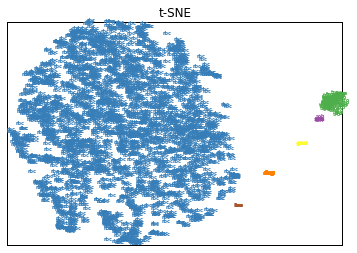

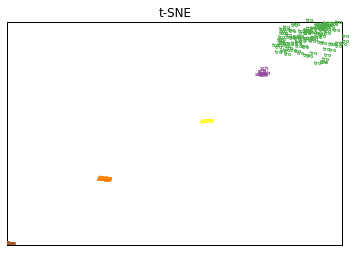

In [39]:
model = TSNE(n_components=2, init='pca', learning_rate=500)
X_tsne = model.fit_transform(X) 
plot_embedding(X_tsne, y, "t-SNE")
plt.show()

idx_noRBC = [i for i in range(len(y)) if y[i] != 1]
plot_embedding(model.fit_transform(X)[idx_noRBC, :], y[idx_noRBC], "t-SNE")
plt.show()

In [77]:
print X_tsne.shape, y.shape

(3632, 2) (3632,)


In [83]:
print X[0], y[0]
print X[1], y[1]

[ 0.63158473  0.66888527] 1.0
[ 0.82750073  0.96985611] 1.0


Computing PCA projection


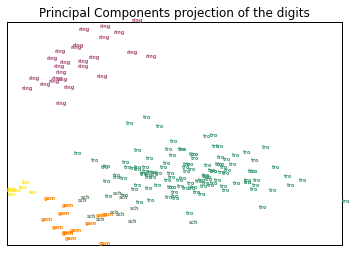

In [125]:
print("Computing PCA projection")
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca, y,
               "Principal Components projection of the digits")


In [123]:
print X[0:4,:]
print y[0:4]
print np.linalg.norm(X[3,:]-X[2,:]), np.linalg.norm(X[0,:]-X[2,:]), np.linalg.norm(X[1,:]-X[2,:])
print 'keep',keep
print boxes
print feat[keep]

[[ 0.          0.          0.         ...,  0.          0.17672095  0.        ]
 [ 0.          0.          0.31423366 ...,  0.23640758  0.65428114  0.        ]
 [ 0.          0.          0.81775099 ...,  0.          0.09576081
   0.15418215]
 [ 0.16469368  0.          0.43200785 ...,  0.          0.          0.27212104]]
[ 2.  3.  4.  4.]
10.6774539679 17.1994096621 20.4291156471
keep []
[[   72.0192337    408.58624268   178.89767456 ...,   408.58624268
    178.89767456   519.28912354]
 [ 1274.47583008   871.43261719  1398.45214844 ...,   871.43261719
   1398.45214844   987.48632812]
 [  778.5043335    408.04611206   895.97869873 ...,   408.04611206
    895.97869873   515.06323242]
 ..., 
 [ 1165.6307373   1136.9185791   1265.84313965 ...,  1136.9185791
   1265.84313965  1199.        ]
 [    0.           279.97463989   130.56930542 ...,   279.97463989
    130.56930542   505.88613892]
 [   42.6852417    160.6222229    173.50012207 ...,   160.6222229
    173.50012207   256.26303101]]
[]


In [9]:
#Faster rcnn
#X: samples x features, 
#y: corresponding labels (according to the ground truth)
X = np.array([]).reshape(0,1024)
y = np.array([])
y_image = np.array([])
NMS_THRESH = 0.3
SCORE_THRESH = 0.65
max_per_image = 200
max_per_set = 100 * num_images
CLASSES = ('bg', 'rbc', 'tro', 'sch', 'ring', 'gam', 'leu', 'diff')
classes = ('rbc', 'tro', 'sch', 'ring', 'gam', 'leu')
MIN_OVERLAP = 0.5
thresh = -np.inf * np.ones(len(CLASSES))
top_scores = [[] for _ in xrange(len(CLASSES))]
box_coordinates = np.array([]).reshape(0,4)
coordinates = []
input_image_file = []
images = []
num_images = 50
for i in xrange(num_images):
    input_image_file.append(filenames[i].strip())
    print i, input_image_file
    img = cv2.imread(os.path.join(data_dir, 'Images', input_image_file[i]+'.jpg'))
    #extract single objects
    with open(os.path.join(data_dir, 'Annotations', input_image_file[i]+'.txt')) as fa:
        annotations = fa.readlines()
    coordinates.append(np.array([np.array(map(int, annotation.strip().split(' ')[:-2])) for annotation in annotations]))
    labels = [annotation.strip().split(' ')[-2] for annotation in annotations]
    difficult = [annotation.strip().split(' ')[-1] for annotation in annotations]
    #print len(coordinates[i]), coordinates[i]
    #runs image through net (Detect object classes in an image given object proposals.)
    scores, boxes = im_detect(net, img, coordinates)
    ''' '''
    #get features from layer
    feat = net.blobs[layer].data  
    for cls in classes:
        cls_ind = CLASSES.index(cls)
        print cls
        keep = np.where(scores[:, cls_ind] >= max(SCORE_THRESH, thresh[cls_ind]))[0]
        #print len(keep)
        cls_boxes = boxes[keep, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[keep, cls_ind]
        cls_feat = feat[keep,:]
        
        top_inds = np.argsort(-cls_scores)[:max_per_image]
        #print len(top_inds)
        cls_scores = cls_scores[top_inds]
        cls_boxes = cls_boxes[top_inds, :]
        cls_feat = cls_feat[top_inds, :]
        
        # push new scores onto the minheap
        for val in cls_scores:
            heapq.heappush(top_scores[cls_ind], val)
            
        # if we've collected more than the max number of detection,
        # then pop items off the minheap and update the class threshold
        if len(top_scores[cls_ind]) > max_per_set:
                while len(top_scores[cls_ind]) > max_per_set:
                    heapq.heappop(top_scores[cls_ind])
                thresh[cls_ind] = top_scores[cls_ind][0]
                print 'more'
        
        dets = np.hstack((cls_boxes,cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        print len(keep)
        #print keep, dets[keep,:]
        dets = dets[keep, :]
        #print len(coordinates), X.shape, cls_feat[keep,:].shape
        #output = net.forward()
    
        #for each detection, match with closest ground truth; if overlap less than threshold, consider ground truth to be background
        for det in dets:
            _boxes = det[:4]
            ov_max = -float("inf")
            for ngt, gt_boxes in enumerate(coordinates[i]):
                iw = min(_boxes[2], gt_boxes[2]) - max(_boxes[0], gt_boxes[0]) + 1
                ih = min(_boxes[3], gt_boxes[3]) - max(_boxes[1], gt_boxes[1]) + 1
                if iw > 0 and ih > 0:
                    #compute overlap as area of intersection / area of union
                    ua = (_boxes[2] - _boxes[0] + 1)*(_boxes[3] - _boxes[1] + 1) + (gt_boxes[2] - gt_boxes[0] + 1)*(gt_boxes[3] - gt_boxes[1] + 1) - iw*ih
                    ov = iw*ih*1.0/ua
                    if ov > ov_max:
                        ov_max = ov
                        ngt_max = ngt
            if ov_max >= MIN_OVERLAP:
                if str(difficult[ngt_max]) != 'True': 
                    y = np.append(y, np.array([CLASSES.index(labels[ngt_max])]))
                else:
                    print difficult[ngt_max], len(difficult), len(coordinates)
                    y = np.append(y, np.array([len(CLASSES)-1]))
            else:
                print ov_max
                y = np.append(y, np.array([0]))
        images.extend([i for x in range(len(keep))])
        box_coordinates = np.concatenate((box_coordinates, cls_boxes[keep, :]), axis = 0)
        X = np.concatenate((X, cls_feat[keep,:]), axis=0)
        y_image = np.append(y_image, np.array([i]*len(keep)))


0 ['g8_t1_up/g6010243_tro_1148.4-252.7-1286.0-377.3_0.jpg 2']


IOError: [Errno 2] No such file or directory: '/home/ubuntu/py-faster-rcnn/caffe-fast-rcnn/data/try1/Annotations/g8_t1_up/g6010243_tro_1148.4-252.7-1286.0-377.3_0.jpg 2.txt'

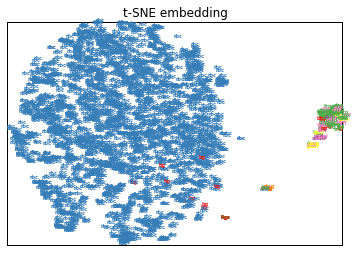

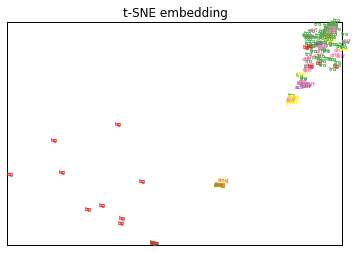

In [45]:

model = TSNE(n_components=2, init='pca', learning_rate=200, n_iter=5000)
X_tsne = model.fit_transform(X) 
plot_embedding(X_tsne, y, "t-SNE embedding", coordinates)
plt.show()
 
idx_noRBC = [i for i in range(len(y)) if y[i] != 1]
plot_embedding(model.fit_transform(X)[idx_noRBC, :], y[idx_noRBC], "t-SNE embedding")
plt.show()



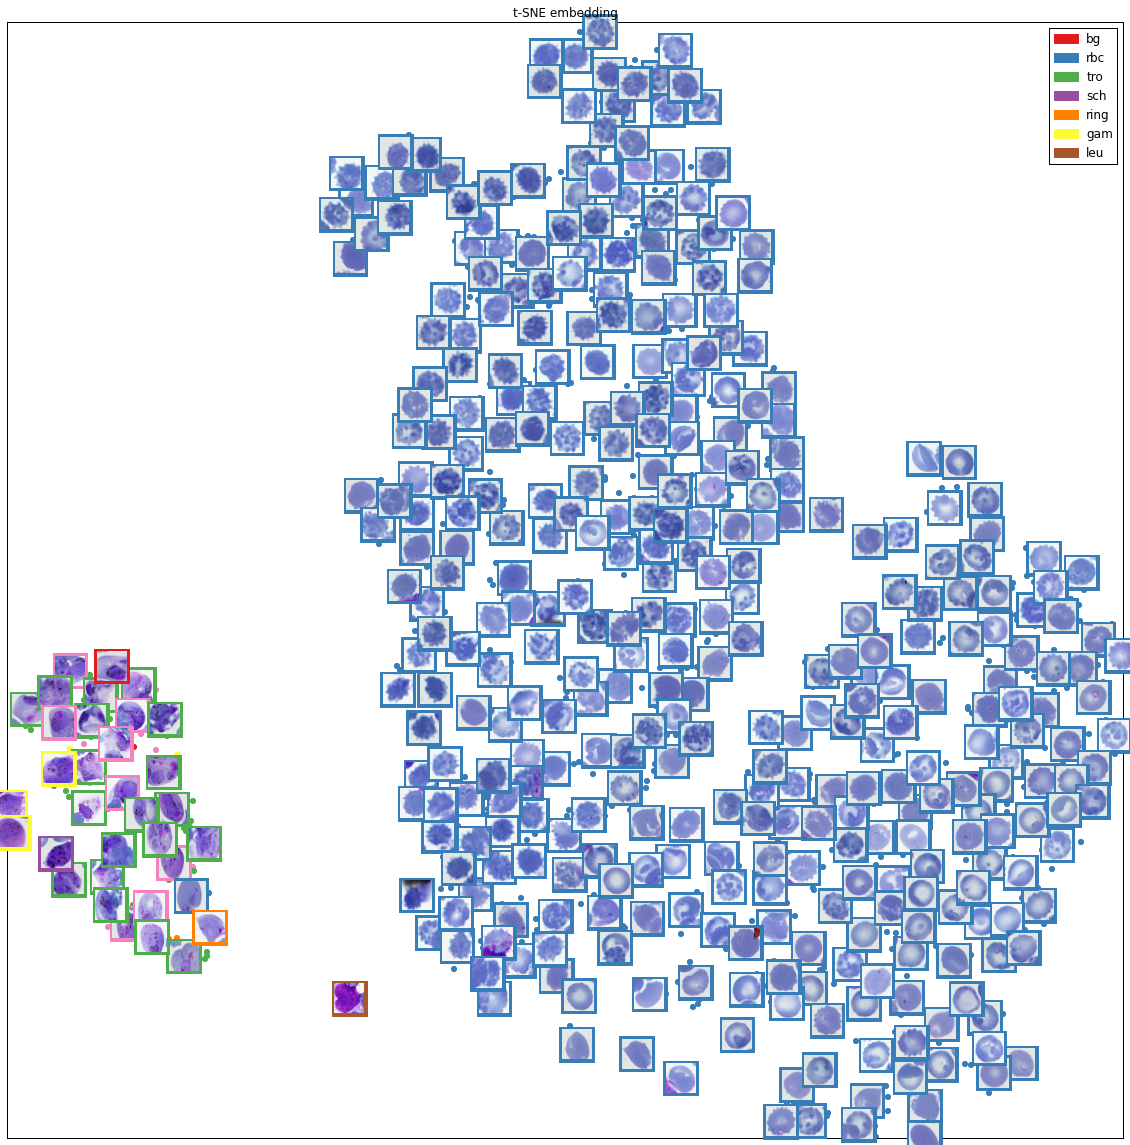

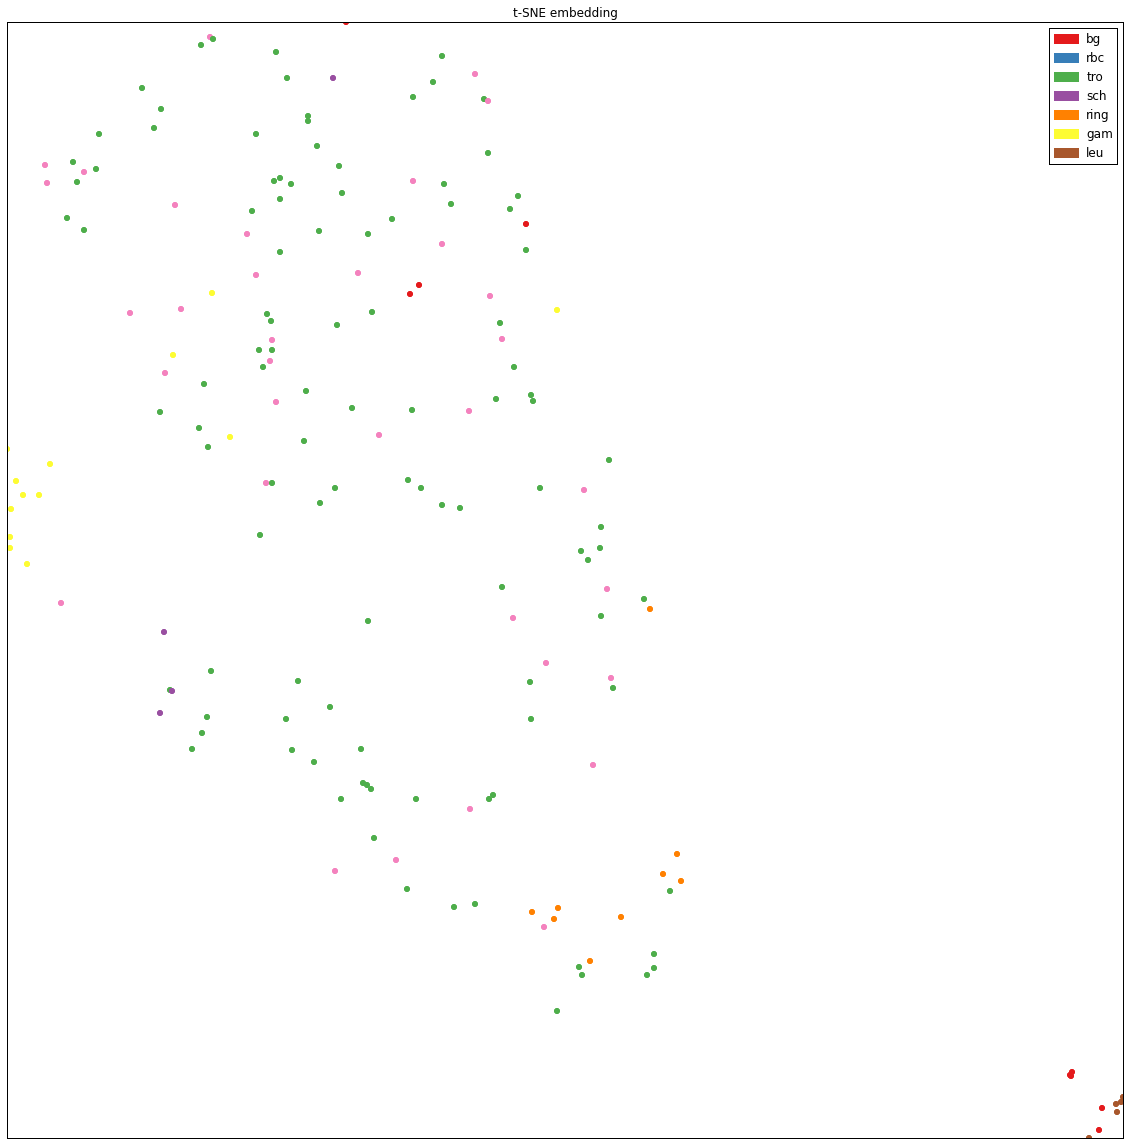

In [95]:
import bhtsne
X_tsne = bhtsne.tsne(X)
#model = TSNE(n_components=2, init='pca', learning_rate=200, n_iter=200)
#X_tsne = model.fit_transform(X) 
plot_embedding(X_tsne, y, "t-SNE embedding", box_coordinates, images)
plt.show()
 
idx_noRBC = [i for i in range(len(y)) if y[i] != 1]
plot_embedding(X_tsne[idx_noRBC, :], y[idx_noRBC], "t-SNE embedding")
plt.show()

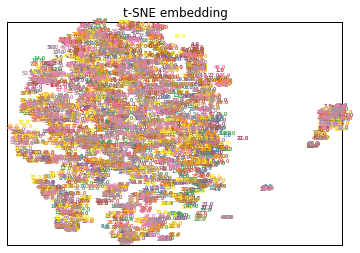

In [49]:
def plot_embedding_imnum(X, y_image, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y_image[i]),
                 color=plt.cm.Set1(y_image[i] / max(y_image)),
                 fontdict={'weight': 'bold', 'size': 5})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
plot_embedding_imnum(X_tsne, y_image, "t-SNE embedding")
plt.show()

In [50]:
#X: samples x features, 
#y: corresponding labels (according to the model output)
#thresholding is done as above
X = np.array([]).reshape(0,1024)
y = np.array([])
y_image = np.array([])
NMS_THRESH = 0.3
SCORE_THRESH = 0.65
max_per_image = 200
max_per_set = 100 * num_images
CLASSES = ('bg', 'rbc', 'tro', 'sch', 'ring', 'gam', 'leu', 'diff')
classes = ('rbc', 'tro', 'sch', 'ring', 'gam', 'leu')
MIN_OVERLAP = 0.5
thresh = -np.inf * np.ones(len(CLASSES))
top_scores = [[] for _ in xrange(len(CLASSES))]
for i in xrange(num_images):
    input_image_file = filenames[i].strip()
    print i, input_image_file
    img = cv2.imread(os.path.join(data_dir, 'Images', input_image_file+'.jpg'))
    #extract single objects
    with open(os.path.join(data_dir, 'Annotations', input_image_file+'.txt')) as fa:
        annotations = fa.readlines()
    coordinates = np.array([np.array(map(int, annotation.strip().split(' ')[:-2])) for annotation in annotations])
    labels = [annotation.strip().split(' ')[-2] for annotation in annotations]
    difficult = [annotation.strip().split(' ')[-1] for annotation in annotations]
    
    #runs image through net (Detect object classes in an image given object proposals.)
    scores, boxes = im_detect(net, img, coordinates)
    
    #get features from layer
    feat = net.blobs[layer].data  
    for cls in classes:
        cls_ind = CLASSES.index(cls)
        print cls
        keep = np.where(scores[:, cls_ind] >= max(SCORE_THRESH, thresh[cls_ind]))[0]
        #print len(keep)
        cls_boxes = boxes[keep, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[keep, cls_ind]
        cls_feat = feat[keep,:]
        
        top_inds = np.argsort(-cls_scores)[:max_per_image]
        #print len(top_inds)
        cls_scores = cls_scores[top_inds]
        cls_boxes = cls_boxes[top_inds, :]
        cls_feat = cls_feat[top_inds, :]
        
        # push new scores onto the minheap
        for val in cls_scores:
            heapq.heappush(top_scores[cls_ind], val)
            
        # if we've collected more than the max number of detection,
        # then pop items off the minheap and update the class threshold
        if len(top_scores[cls_ind]) > max_per_set:
                while len(top_scores[cls_ind]) > max_per_set:
                    heapq.heappop(top_scores[cls_ind])
                thresh[cls_ind] = top_scores[cls_ind][0]
                print 'more'
        
        dets = np.hstack((cls_boxes,cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)

        #print len(coordinates), X.shape, cls_feat[keep,:].shape
        #output = net.forward()
    
        X = np.concatenate((X, cls_feat[keep,:]), axis=0)
        y = np.append(y, np.array([cls_ind]*len(keep)))


0 g8_t1_up/g6010106
rbc
tro
sch
ring
gam
leu
1 g8_t1_up/g6010133
rbc
tro
sch
ring
gam
leu
2 g8_t1_up/g6010196
rbc
tro
sch
ring
gam
leu
3 g8_t1_up/g6010153
rbc
tro
sch
ring
gam
leu
4 g8_t1_up/g6010091
rbc
tro
sch
ring
gam
leu
5 g8_t1_up/g6010159
rbc
tro
sch
ring
gam
leu
6 g8_t1_up/g6010273
rbc
tro
sch
ring
gam
leu
7 g8_t1_up/g6010017
rbc
tro
sch
ring
gam
leu
8 g8_t1_up/g6010003
rbc
tro
sch
ring
gam
leu
9 g8_t1_up/g6010072
rbc
tro
sch
ring
gam
leu
10 g8_t1_up/g6010168
rbc
tro
sch
ring
gam
leu
11 g8_t1_up/g6010287
rbc
tro
sch
ring
gam
leu
12 g8_t1_up/g6010138
rbc
tro
sch
ring
gam
leu
13 g8_t1_up/g6010282
rbc
tro
sch
ring
gam
leu
14 g8_t1_up/g6010152
rbc
tro
sch
ring
gam
leu
15 g8_t1_up/g6010210
rbc
tro
sch
ring
gam
leu
16 g8_t1_up/g6010126
rbc
tro
sch
ring
gam
leu
17 g8_t1_up/g6010137
rbc
tro
sch
ring
gam
leu
18 g8_t1_up/g6010008
rbc
tro
sch
ring
gam
leu
19 g8_t1_up/g6010149
rbc
tro
sch
ring
gam
leu
20 g8_t1_up/g6010170
rbc
tro
sch
ring
gam
leu
21 g8_t1_up/g6010117
rbc
tro
sch
ring
gam
le

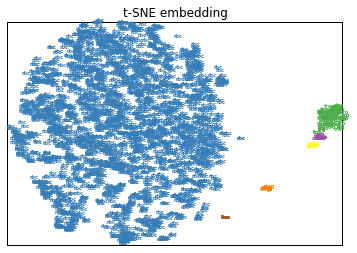

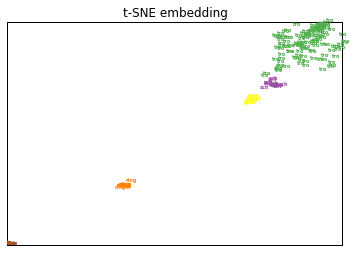

In [51]:
model = TSNE(n_components=2, init='pca', learning_rate=500)
X_tsne = model.fit_transform(X) 
plot_embedding(X_tsne, y, "t-SNE embedding")
plt.show()

idx_noRBC = [i for i in range(len(y)) if y[i] != 1]
plot_embedding(model.fit_transform(X)[idx_noRBC, :], y[idx_noRBC], "t-SNE embedding")
plt.show()

In [5]:
## CAFFENET
#X: samples x features, 
#y: corresponding labels (according to the ground truth)
X = np.array([]).reshape(0,4096)
y = np.array([]) #main annotator 
y_model = np.array([])
y_other = np.array([]) #other annotator
NMS_THRESH = 0.3
#SCORE_THRESH = 0.5
#max_per_image = 200
#max_per_set = 100 * num_images
CLASSES = ('bg', 'rbc', 'tro', 'sch', 'ring', 'gam', 'leu', 'diff')
classes = ('rbc', 'tro', 'sch', 'ring', 'gam', 'leu')
MIN_OVERLAP = 0.5
thresh = -np.inf * np.ones(len(CLASSES))
top_scores = [[] for _ in xrange(len(CLASSES))]
box_coordinates = np.array([]).reshape(0,4)
coordinates = []
input_image_file = []
images = []
num_objects = len(filenames) 
data_dir = '/home/ubuntu/py-faster-rcnn/caffe-fast-rcnn/'

#other annotations
other_annotations = []
with open('/home/ubuntu/compareAnnotationsOutput.txt', 'r') as f:
    objects = f.readlines()
for obj in objects:
    obj = obj.strip().split(' [')
    index = 'g8_t1_up/'+obj[0]
    coord1 = obj[1].split(']')[0].split(',')
    #coord2 = obj[2].split('] ')[0].split(',')
    class1 = obj[2].split('] ')[1].split(' ')[0]
    #class2 = obj[2].split('] ')[1].split(' ')[1]
    if class1 == 'difficult':
        class1 = 'diff'
    other_annotations.append([index, coord1, class1])
    
for i in xrange(num_objects):
    obj_info = filenames[i].strip().split(' ')
    input_image_file.append(obj_info[0])
    obj_filename = obj_info[0].split('.jpg')[0]
    obj_filename = obj_filename.split('/')
    index = obj_filename[0]
    obj_filename = obj_filename[1].split('_')
    index += '/'+obj_filename[0]
    gt_class = obj_filename[1]
    gt_boxes = [float(x) for x in obj_filename[2].split('-')]
    #print index, gt_class, gt_boxes
    
    #img = cv2.imread(os.path.join(data_dir, 'examples', 'try1', 'test', input_image_file[i]+'.jpg'))
    label = int(obj_info[1])
    
    #run through 
    img = caffe.io.load_image(os.path.join(data_dir, 'examples', 'try1', 'test', input_image_file[i]))
    net.blobs['data'].reshape(1, 3, 227,227)
    net.blobs['data'].data[...] = transformer.preprocess('data', img)
    output = net.forward()
    
    #get features from layer
    feat = net.blobs[layer].data  
    
    X = np.concatenate((X, feat), axis=0)
    y_model = np.append(y_model, np.array([np.argmax(output['prob'])]))
    y = np.append(y, np.array([label]))
    
    #match ground truth with other annotation
    ov_max = -float("inf")
    for other in other_annotations:
        if other[0] == index and len(other[1])==4:
            _boxes = [int(x) for x in other[1]]
            iw = min(_boxes[2], gt_boxes[2]) - max(_boxes[0], gt_boxes[0]) + 1
            ih = min(_boxes[3], gt_boxes[3]) - max(_boxes[1], gt_boxes[1]) + 1
            if iw > 0 and ih > 0:
                #compute overlap as area of intersection / area of union
                ua = (_boxes[2] - _boxes[0] + 1)*(_boxes[3] - _boxes[1] + 1) + (gt_boxes[2] - gt_boxes[0] + 1)*(gt_boxes[3] - gt_boxes[1] + 1) - iw*ih
                ov = iw*ih*1.0/ua
                if ov > ov_max:
                    ov_max = ov
                    other_label = other[2]
    if ov_max >= MIN_OVERLAP:
        other_label = CLASSES.index(other_label)
    else:
        other_label = 0
    #print other_label        
    y_other = np.append(y_other, np.array([other_label]))
    print i, input_image_file[i], y_model[-1], y[-1], y_other[-1]


0 g8_t1_up/g6010286_None_573.4-316.5-669.9-478.5_0.jpg 0.0 0.0 0.0
1 g8_t1_up/g6010002_gam_186.2-676.5-315.0-821.0_0.jpg 2.0 7.0 5.0
2 g8_t1_up/g6010188_tro_318.0-532.8-455.2-647.8_0.jpg 2.0 2.0 2.0
3 g8_t1_up/g6010095_rbc_487.3-245.6-607.2-351.0_0.jpg 1.0 1.0 0.0
4 g8_t1_up/g6010179_tro_1390.2-641.3-1512.9-762.3_0.jpg 2.0 2.0 3.0
5 g8_t1_up/g6010177_tro_39.9-240.8-174.0-385.4_0.jpg 2.0 2.0 7.0
6 g8_t1_up/g6010018_tro_39.1-1071.5-168.9-1186.4_0.jpg 2.0 2.0 3.0
7 g8_t1_up/g6010176_tro_476.3-676.8-600.4-805.0_0.jpg 2.0 2.0 2.0
8 g8_t1_up/g6010084_tro_327.2-245.6-460.7-362.6_0.jpg 2.0 2.0 7.0
9 g8_t1_up/g6010217_None_290.2-77.7-369.8-158.4_0.jpg 0.0 0.0 7.0
10 g8_t1_up/g6010237_ring_810.1-351.9-935.1-472.5_0.jpg 4.0 4.0 0.0
11 g8_t1_up/g6010233_gam_1347.6-521.9-1483.0-643.1_0.jpg 2.0 7.0 7.0
12 g8_t1_up/g6010228_gam_1247.3-958.7-1353.0-1093.2_0.jpg 2.0 7.0 5.0
13 g8_t1_up/g6010244_tro_1415.1-564.9-1559.3-678.1_0.jpg 4.0 2.0 2.0
14 g8_t1_up/g6010176_tro_533.5-87.5-668.6-222.5_0.jpg 2.0 2.0

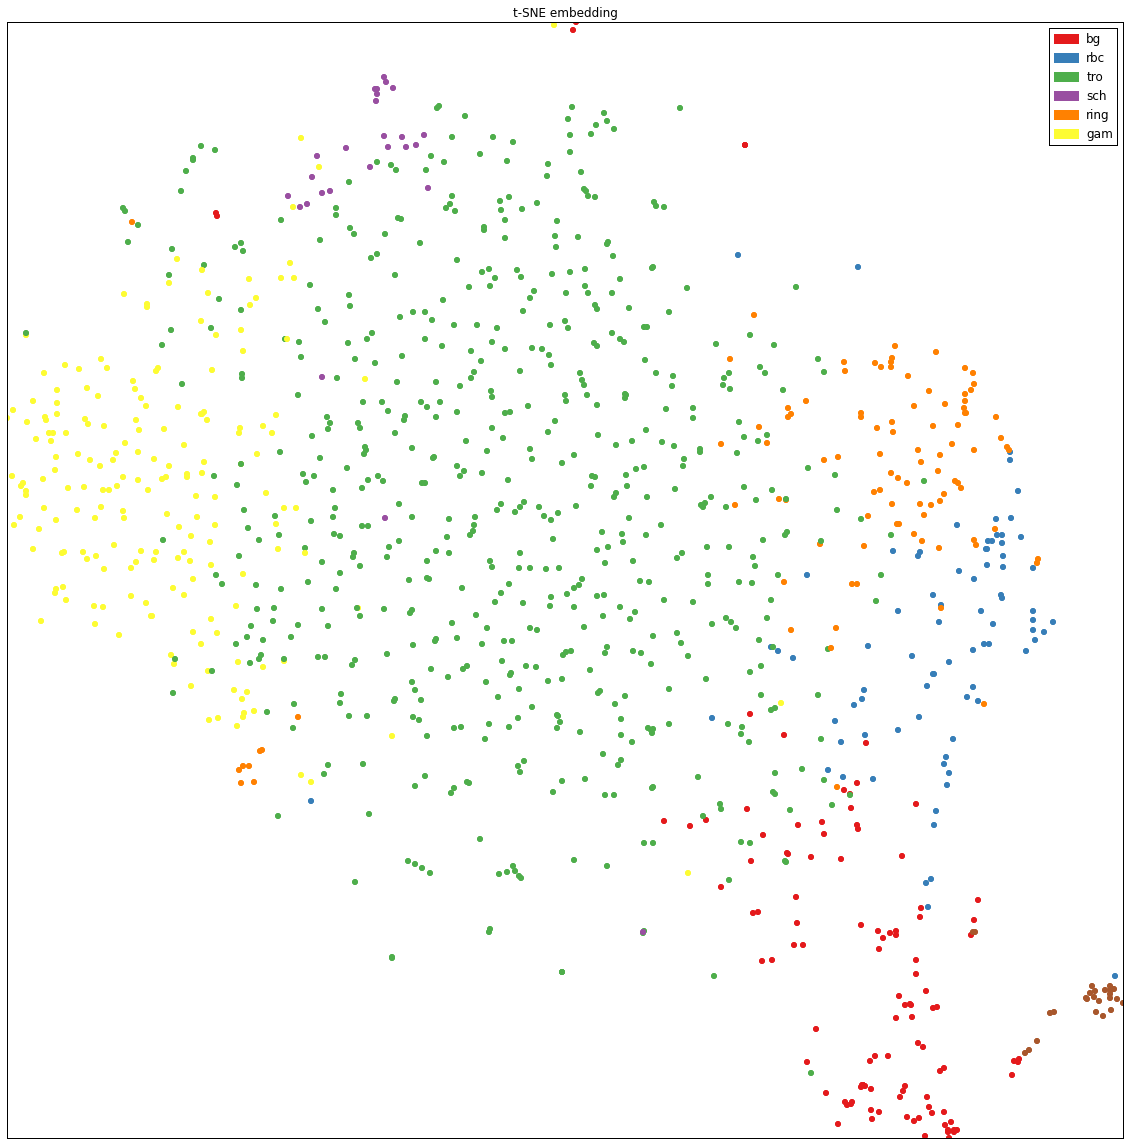

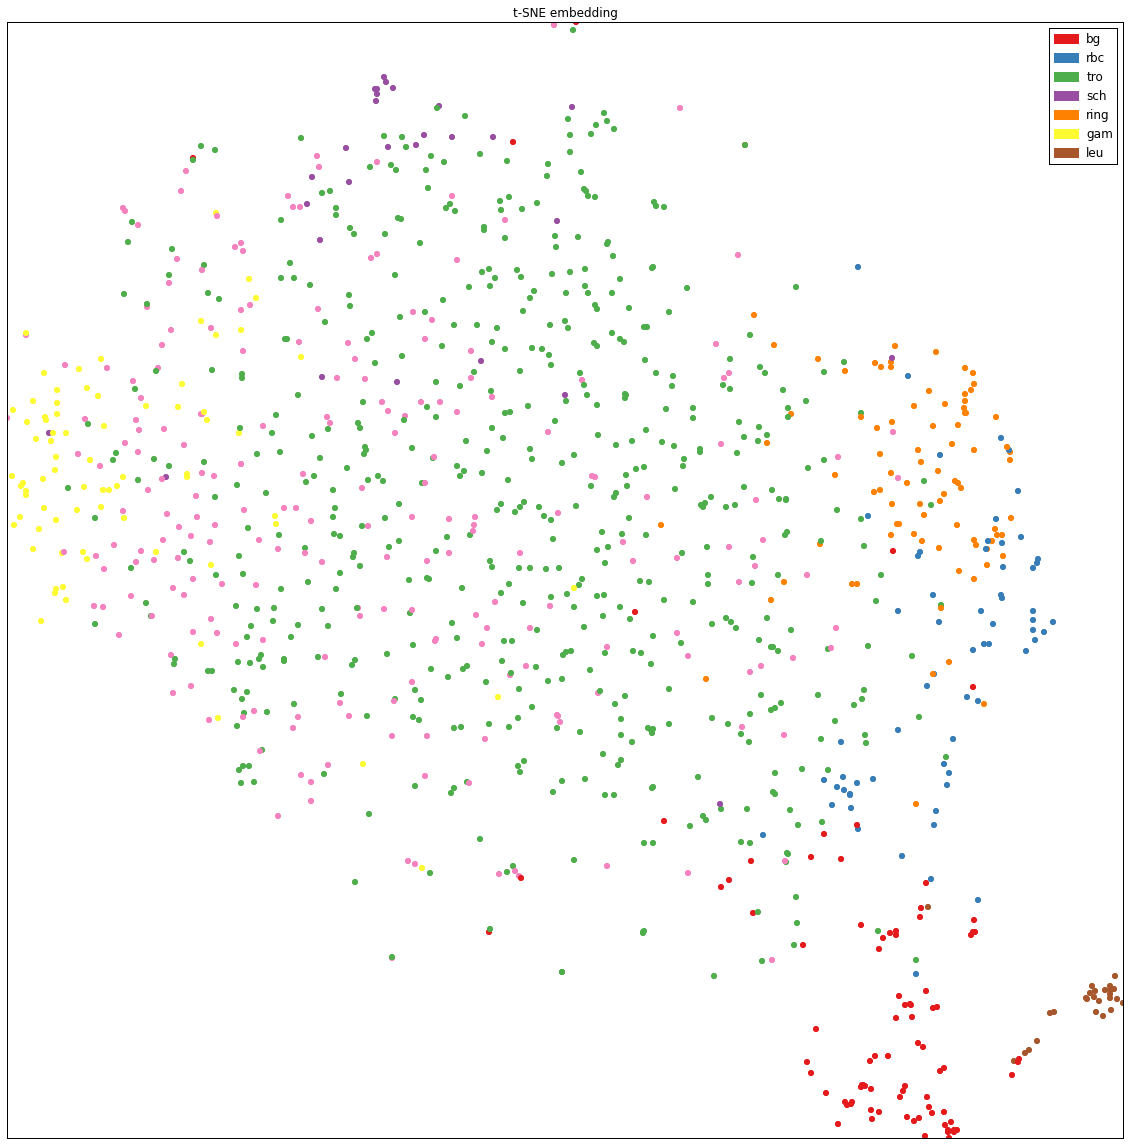

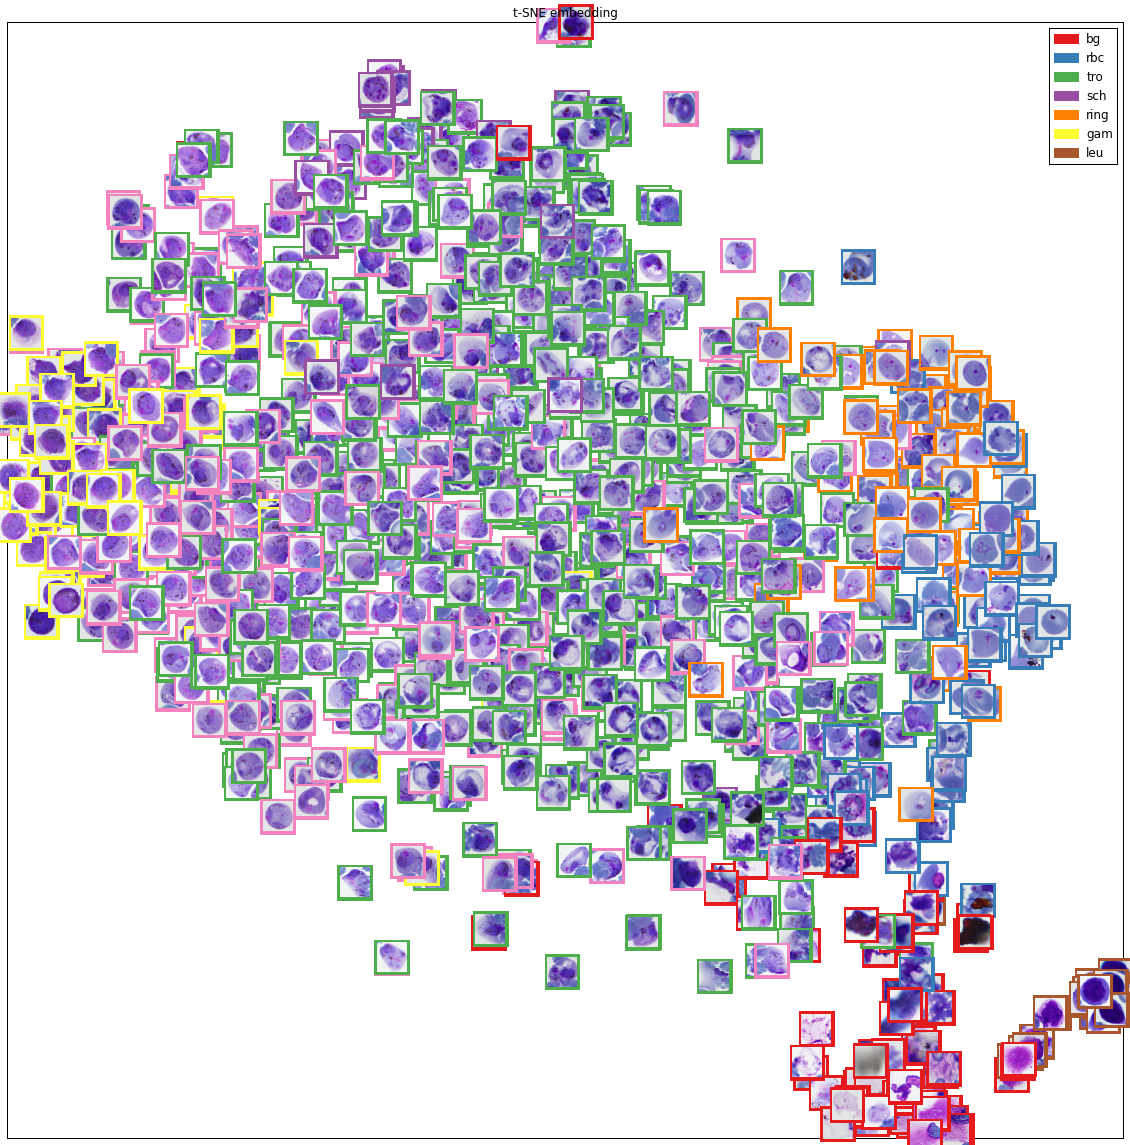

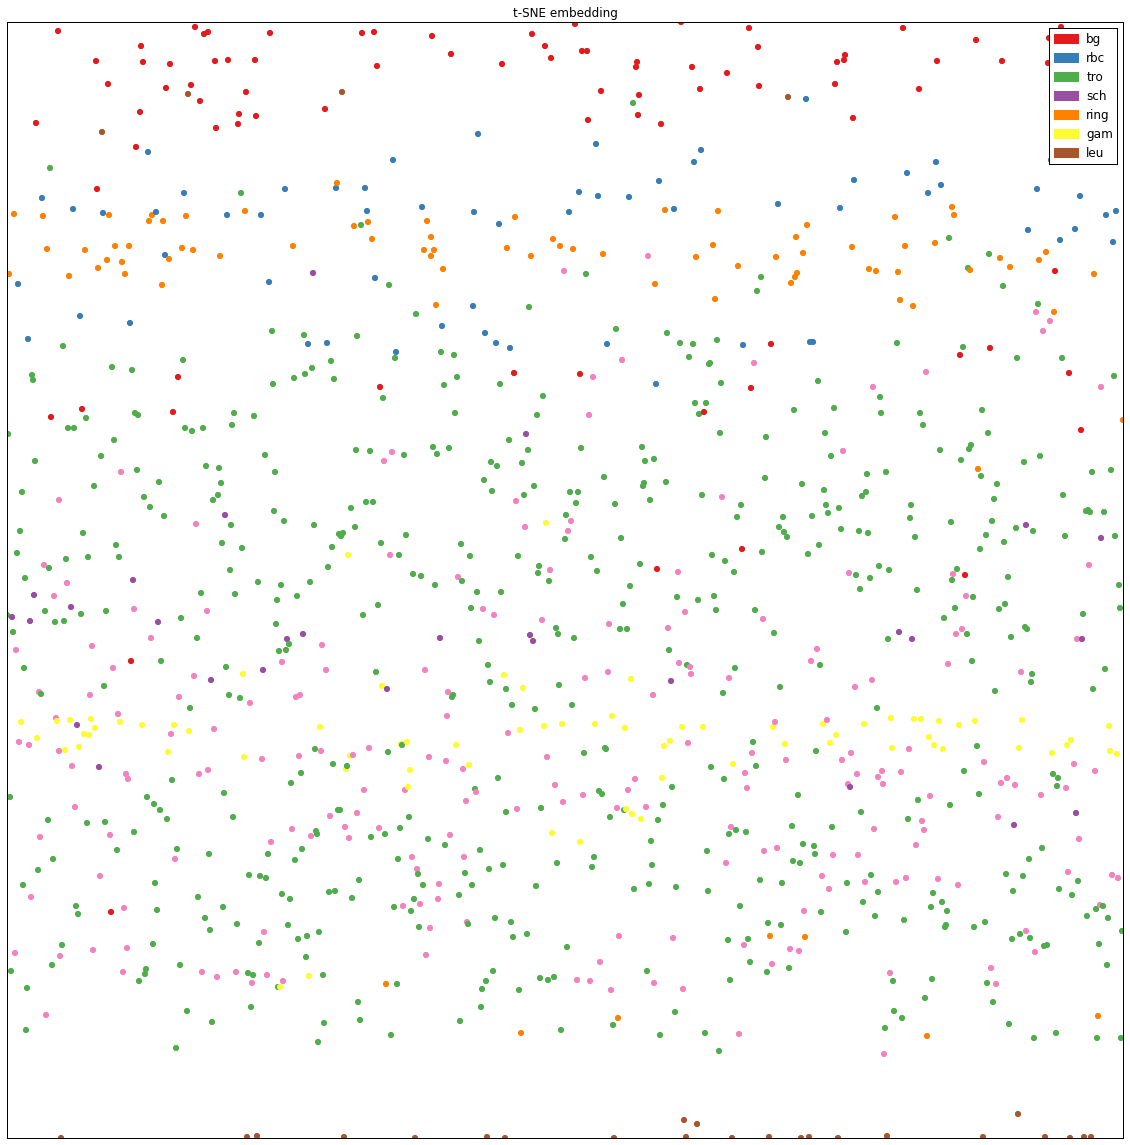

In [47]:
import bhtsne
num_points = 915
#X_tsne = bhtsne.tsne(X[0:num_points, :], perplexity=50)
X_tsne = bhtsne.tsne(X, perplexity=30)
#model = TSNE(n_components=2, init='pca', learning_rate=500, perplexity=30.0, n_iter=10000, n_iter_without_progress=1000)
#X_tsne = model.fit_transform(X) 
#plot_embedding(X_tsne, y_model[0:num_points], "t-SNE embedding")
plot_embedding(X_tsne, y_model, "t-SNE embedding")
plt.show()

plot_embedding(X_tsne, y, "t-SNE embedding")
plt.show()


plot_embedding(X_tsne, y, "t-SNE embedding", images=input_image_file)
plt.show()


model = TSNE(n_components=1, learning_rate=500, n_iter=10000,n_iter_without_progress=1000)
X_tsne1 = model.fit_transform(X) 
plot_embedding(np.insert(X_tsne1, 0, range(len(X_tsne1)), axis=1), y, "t-SNE embedding")

#idx_noRBC = [i for i in range(len(y)) if y[i] != 1]
#plot_embedding(X_tsne[idx_noRBC, :], y[idx_noRBC], "t-SNE embedding")
#plt.show()




[ 8.95834156] [-10.41844803]


(array([ 27.,  31.,  74.,  75.,  79.,  75.,  78.,  86.,  81.,  83.,  77.,
         72.,  47.,  45.,  44.,  23.,  55.,  43.,   7.]),
 array([-11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
          2,   3,   4,   5,   6,   7,   8]),
 <a list of 19 Patch objects>)

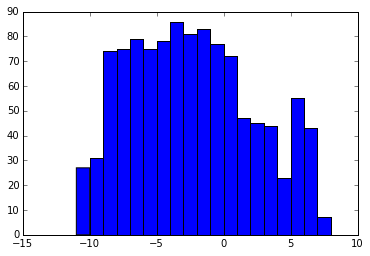

In [45]:
print max(X_tsne1), min(X_tsne1)
plt.hist(X_tsne1, bins=range(-11, 9))

802 137


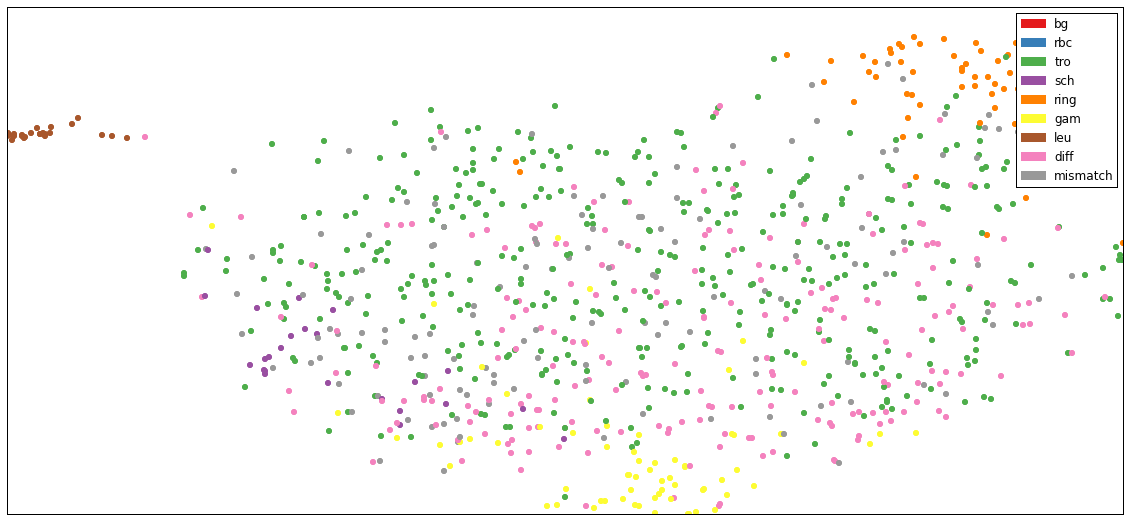

In [38]:
#compare 2 annotations
import bhtsne
num_points = 915
#X_tsne = bhtsne.tsne(X[0:num_points, :], perplexity=50)

subset =[x for x in range(len(y_other)) if y[x] !=0 and y[x]!=1 and y_other[x] != 0 and y_other[x] != 1]

X_tsne = bhtsne.tsne(X, perplexity=30)
plot_2annotations(X_tsne, y, y_other, subset, images=False)#input_image_file)
#plot_2annotations(X_tsne, y, y_other, images=False)#input_image_file)
plt.show()
 

['g8_t1_up/g6010217_102_0_0.jpg', '7']


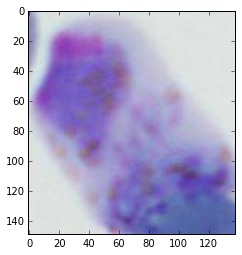

In [14]:
obj_info = filenames[0].strip().split(' ')
print obj_info
from PIL import Image
from matplotlib.pyplot import imshow

im = Image.open(os.path.join(data_dir, 'examples', 'try1', 'test', obj_info[0]), 'r')
imshow(im)

In [15]:
print output
y_model

{'prob': array([[  9.95632350e-01,   9.47932072e-04,   1.97545649e-03,
          1.02576229e-03,   3.98525088e-07,   2.77280324e-05,
          3.90397327e-04]], dtype=float32)}


array([ 0.])

In [62]:
print len([1 for i in range(len(y)) if y[i]==y_model[i]])
print len(y)-len([1 for i in range(len(y)) if y[i] == 7])

print len([1 for i in range(len(y)) if y[i]==y_model[i] and y[i] !=0 and y[i] != 1])
print len(y)-len([1 for i in range(len(y)) if y[i] == 7 or y[i] == 0 or y[i] == 1])

from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y, y_model)
print cm
from sklearn.metrics import f1_score

y_notdiff_ind = np.array([i for i in range(len(y)) if y[i]!=7])
print f1_score(y[y_notdiff_ind], y_model[y_notdiff_ind], average=None)
print confusion_matrix(y[y_notdiff_ind], y_model[y_notdiff_ind])
for i in range(cm.shape[0]):
    print (cm[i,:-1].sum()+cm[:-1,i].sum())
    print 2.0*cm[i,i]/(cm[i,:-1].sum()+cm[:-1,i].sum())

685
915
596
764
[[ 62   5  10   1   3   1   6   0]
 [ 13  27   7   1  15   0   0   0]
 [  2  13 427  76  15  18   0   0]
 [  0   0   6  20   1   1   0   0]
 [  0  10   8   1  64   0   0   0]
 [  0   0  15   2   0  58   0   0]
 [  0   0   0   0   0   0  27   0]
 [  0   4 132  25   2  52   2   0]]
[ 0.75151515  0.45762712  0.83398438  0.31007752  0.70718232  0.75816993
  0.9       ]
[[ 62   5  10   1   3   1   6]
 [ 13  27   7   1  15   0   0]
 [  2  13 427  76  15  18   0]
 [  0   0   6  20   1   1   0]
 [  0  10   8   1  64   0   0]
 [  0   0  15   2   0  58   0]
 [  0   0   0   0   0   0  27]]
165
0.751515151515
118
0.457627118644
1024
0.833984375
129
0.31007751938
181
0.707182320442
153
0.758169934641
60
0.9
217
0.0


In [10]:
print len([1 for i in range(len(y)) if y[i]==y_model[i]])
print len(y)-len([1 for i in range(len(y)) if y[i] == 7])

print len([1 for i in range(len(y)) if y[i]==y_model[i] and y[i] !=0 and y[i] != 1])
print len(y)-len([1 for i in range(len(y)) if y[i] == 7 or y[i] == 0 or y[i] == 1])

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, y_model)
print cm 

from sklearn.metrics import f1_score, accuracy_score
y_notdiff_ind = np.array([i for i in range(len(y)) if y[i]!=7])
print f1_score(y[y_notdiff_ind], y_model[y_notdiff_ind], average=None)
acc_num = 0 
acc_den = 0
for i in range(2, cm.shape[0]-1):
    print 2.0*cm[i,i]/(cm[i,:-1].sum()+cm[:-1,i].sum())
    acc_num += cm[i,i]
acc_den += cm.sum() - cm[-1,:].sum() - cm[:2,:2].sum()
print acc_num, acc_den, 1.0*acc_num/acc_den
accuracy_score(y[y_notdiff_ind], y_model[y_notdiff_ind])

686
915
576
764
[[ 71   4   7   0   0   1   5   0]
 [ 16  39   2   0   6   0   0   0]
 [ 15  14 429  27  35  31   0   0]
 [  0   0  11  10   1   6   0   0]
 [  1  24  11   0  47   0   0   0]
 [  0   0   8   2   0  65   0   0]
 [  2   0   0   0   0   0  25   0]
 [  0   3 132  16   9  57   0   0]]
[ 0.7357513   0.54166667  0.84200196  0.29850746  0.54651163  0.73033708
  0.87719298]
0.842001962709
0.298507462687
0.546511627907
0.730337078652
0.877192982456
576 785 0.733757961783


0.74972677595628412

In [17]:
cm =np.array([[ 76 ,  3 ,  7 ,  0 ,  0 ,  0 ,  2   ,0],
 [ 13 , 43 ,  3 ,  0 ,  4 ,  0 ,  0 ,  0],
 [ 23 , 15 ,440 ,  1 , 13 , 59 ,  0 ,  0],
 [  0 ,  0 , 14 ,  8 ,  1 ,  5 ,  0 ,  0],
 [  2 , 27 , 10 ,  0 , 44 ,  0 ,  0 ,  0],
 [  1 ,  0 ,  6 ,  0 ,  0 , 68 ,  0 ,  0],
 [  1  , 1 ,  0 ,  0 ,  0 ,  0 , 25 ,  0],
 [  4  , 5 ,119  , 1 ,  5 , 83 ,  0 ,  0]])
acc_num = 0 
acc_den = 0
for i in range(2, cm.shape[0]-1):
    print 2.0*cm[i,i]/(cm[i,:-1].sum()+cm[:-1,i].sum())
    acc_num += cm[i,i]
acc_den += cm.sum() - cm[-1,:].sum() - cm[:2,:2].sum()
print acc_num, acc_den, 1.0*acc_num/acc_den

0.853540252182
0.432432432432
0.606896551724
0.657004830918
0.925925925926
585 780 0.75


In [64]:
from sklearn.metrics import confusion_matrix

print confusion_matrix(y_other, y_model)
y_notdiff_ind = np.array([i for i in range(len(y_other)) if y_other[i]!=7])
print f1_score(y_other[y_notdiff_ind], y_model[y_notdiff_ind], average=None)

[[ 74  40  31   2  28   0   9   0]
 [  0   0   0   0   0   0   0   0]
 [  0   6 327  50  23  29   0   0]
 [  0   0  42  45   0  10   1   0]
 [  0   2   1   1  35   0   0   0]
 [  0   6 126  20   1  87   0   0]
 [  0   0   0   0   0   0  23   0]
 [  3   5  78   8  13   4   2   0]]
[ 0.57364341  0.          0.67983368  0.41666667  0.55555556  0.47540984
  0.82142857]


In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_other, y_model)
print cm 

y_notdiff_ind = np.array([i for i in range(len(y_other)) if y_other[i]!=7])
print f1_score(y_other[y_notdiff_ind], y_model[y_notdiff_ind], average=None)
acc_num = 0 
acc_den = 0
for i in range(2, cm.shape[0]-1):
    print 2.0*cm[i,i]/(cm[i,:-1].sum()+cm[:-1,i].sum())
    acc_num += cm[i,i]
acc_den += cm.sum() - cm[-1,:].sum() - cm[:2,:2].sum()
print acc_num, acc_den, 1.0*acc_num/acc_den

[[ 90  48  23   0  16   0   7   0]
 [  0   0   0   0   0   0   0   0]
 [  2   9 329  22  38  35   0   0]
 [  0   0  49  18   1  30   0   0]
 [  0  13   1   0  25   0   0   0]
 [  3   4 122  12   9  90   0   0]
 [  0   0   0   0   0   0  23   0]
 [ 10  10  76   3   9   5   0   0]]
[ 0.64516129  0.          0.68613139  0.24        0.390625    0.4556962
  0.86792453]
0.686131386861
0.24
0.390625
0.455696202532
0.867924528302
485 881 0.550510783201


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [77]:
agree =[[y[x], y_model[x]] for x in range(len(y_other)) if y_other[x]==y[x] and y_model[x] !=y[x] if y[x] !=0 and y[x]!=1 and y[x]!=7]
print agree
print len(agree)
print len([1 for x in range(len(y)) if y_other[x] == y[x] and y[x] !=0 and y[x]!=1 and y[x]!=7])

[[5.0, 3.0], [4.0, 1.0], [2.0, 3.0], [3.0, 2.0], [2.0, 5.0], [4.0, 1.0], [2.0, 3.0], [2.0, 3.0], [2.0, 4.0], [4.0, 1.0], [2.0, 3.0], [2.0, 5.0], [3.0, 2.0], [2.0, 5.0], [2.0, 3.0], [4.0, 1.0], [3.0, 2.0], [2.0, 3.0], [5.0, 2.0], [2.0, 3.0], [5.0, 2.0], [2.0, 3.0], [2.0, 5.0], [2.0, 4.0], [2.0, 1.0], [4.0, 3.0], [4.0, 1.0], [2.0, 1.0], [2.0, 3.0], [2.0, 4.0], [2.0, 5.0], [2.0, 4.0], [2.0, 5.0], [2.0, 1.0], [2.0, 5.0], [2.0, 3.0], [2.0, 3.0], [2.0, 5.0], [4.0, 1.0], [2.0, 1.0], [2.0, 4.0], [2.0, 4.0], [2.0, 1.0], [2.0, 4.0], [2.0, 4.0], [2.0, 5.0], [4.0, 1.0], [4.0, 1.0], [2.0, 5.0], [2.0, 3.0], [4.0, 1.0], [2.0, 5.0], [2.0, 3.0], [4.0, 1.0], [2.0, 1.0], [5.0, 2.0], [2.0, 4.0], [2.0, 3.0], [2.0, 5.0], [2.0, 3.0], [2.0, 5.0], [2.0, 4.0], [2.0, 3.0], [3.0, 5.0], [2.0, 4.0], [2.0, 3.0], [2.0, 4.0], [2.0, 1.0], [2.0, 5.0], [2.0, 4.0], [2.0, 3.0], [2.0, 3.0], [2.0, 3.0], [3.0, 2.0], [4.0, 1.0], [2.0, 1.0], [4.0, 1.0], [3.0, 5.0], [2.0, 4.0], [2.0, 4.0], [2.0, 3.0], [2.0, 3.0], [2.0, 5.0], [2.

In [30]:
## show results compared to other annotator

#open file
with open('/home/ubuntu/compareAnnotationsOutput.txt', 'r') as f:
    objects = f.readlines()
print objects[0].strip().split(' [')
print objects[0].strip().split(' [')[1].split(']')[0].split(',')
print objects[0].strip().split(' [')[2].split('] ')[0].split(',')
print objects[0].strip().split(' [')[2].split('] ')[1].split(' ')

other_annotations = []
with open('/home/ubuntu/compareAnnotationsOutput.txt', 'r') as f:
    objects = f.readlines()
for obj in objects:
    obj = obj.strip().split(' [')
    index = 'g8_t1_up/'+obj[0]
    coord1 = obj[1].split(']')[0].split(',')
    coord2 = obj[2].split('] ')[0].split(',')
    class1 = obj[2].split('] ')[1].split(' ')[0]
    class2 = obj[2].split('] ')[1].split(' ')[1]
    other_annotations.append([index, coord1, class1])
print other_annotations

['g6010001', '350, 55, 491, 188]', '386, 62, 484, 179] sch tro']
['350', ' 55', ' 491', ' 188']
['386', ' 62', ' 484', ' 179']
['sch', 'tro']
[['g8_t1_up/g6010001', ['350', ' 55', ' 491', ' 188'], 'sch'], ['g8_t1_up/g6010001', ['1355', ' 169', ' 1497', ' 312'], 'difficult'], ['g8_t1_up/g6010001', ['362', ' 633', ' 493', ' 743'], 'gam'], ['g8_t1_up/g6010002', ['836', ' 424', ' 971', ' 572'], 'tro'], ['g8_t1_up/g6010002', ['172', ' 690', ' 319', ' 828'], 'gam'], ['g8_t1_up/g6010003', ['541', ' 222', ' 693', ' 378'], 'gam'], ['g8_t1_up/g6010003', ['21', ' 800', ' 179', ' 910'], 'difficult'], ['g8_t1_up/g6010003', ['26', ' 159', ' 136', ' 305'], 'sch'], ['g8_t1_up/g6010003', ['107', ' 167', ' 217', ' 297'], 'difficult'], ['g8_t1_up/g6010003', ['1216', ' 966', ' 1329', ' 1084'], 'gam'], ['g8_t1_up/g6010003', ['1381', ' 810', ' 1498', ' 945'], 'gam'], ['g8_t1_up/g6010003', ['1110', ' 862', ' 1250', ' 981'], 'gam'], ['g8_t1_up/g6010004', ['812', ' 169', ' 929', ' 297'], 'difficult'], ['g8_t1_

In [47]:
filenames

['g8_t1_up/g6010136_tro_677.3-830.1-790.1-999.9.jpg 2\n',
 'g8_t1_up/g6010273_ring_392.9-789.9-508.7-928.7.jpg 4\n',
 'g8_t1_up/g6010019_tro_430.1-985.6-571.6-1114.8.jpg 2\n',
 'g8_t1_up/g6010268_gam_280.4-344.9-454.1-509.6.jpg 7\n',
 'g8_t1_up/g6010188_tro_63.1-116.6-192.0-255.3.jpg 2\n',
 'g8_t1_up/g6010299_gam_1154.5-859.7-1301.9-994.8.jpg 7\n',
 'g8_t1_up/g6010179_tro_820.2-736.9-965.5-878.8.jpg 2\n',
 'g8_t1_up/g6010058_gam_1180.6-87.5-1312.4-232.5.jpg 7\n',
 'g8_t1_up/g6010016_tro_417.3-403.2-550.9-533.0.jpg 2\n',
 'g8_t1_up/g6010069_gam_164.1-280.0-309.1-438.7.jpg 7\n',
 'g8_t1_up/g6010265_None_1520.2-1053.0-1599.0-1175.1.jpg 0\n',
 'g8_t1_up/g6010044_None_369.6-288.5-515.0-517.7.jpg 0\n',
 'g8_t1_up/g6010112_sch_887.9-161.3-1005.3-292.6.jpg 3\n',
 'g8_t1_up/g6010020_gam_1160.2-894.3-1300.5-1006.2.jpg 5\n',
 'g8_t1_up/g6010090_None_568.5-154.5-683.6-256.0.jpg 0\n',
 'g8_t1_up/g6010084_tro_327.2-245.6-460.7-362.6.jpg 2\n',
 'g8_t1_up/g6010240_tro_660.5-757.1-796.2-891.6.jpg 2\n',

('bg', 'rbc', 'tro', 'sch', 'ring', 'gam', 'leu', 'diff')